In [5]:
import torch
torch.set_default_dtype(torch.float)
#import pylibnxc
import numpy as np
import pandas as pd
from ase.io import read
from dpyscfl.net import *
from dpyscfl.scf import *
from dpyscfl.utils import *
from dpyscfl.losses import *
from ase.units import Bohr, Hartree
import os, sys, argparse, psutil, pickle, threading, signal
from opt_einsum import contract
import matplotlib.pyplot as plt

In [80]:
trp = '/home/awills/Documents/Research/swxcd/train/pt/scan/pop/2022-07-26_18:10:24.788495testrun.dat'
evp = '/home/awills/Documents/Research/swxcd/eval/pt/scan/table.dat'
ccp = '/home/awills/Documents/Research/swxcd/aegis/rhscanrxn/progress'

cc = pd.read_csv(ccp, sep='\t')
ev = pd.read_csv(evp, sep='\t')
tr = pd.read_csv(trp, sep='\t', names = ['idx','form','sym','e','conv','sc'], header=0)

cce = cc[[cc.columns[0], cc.columns[2]]]
eve = ev[[ev.columns[0], ev.columns[2]]]
tre = tr[['idx', 'e']]
tre.loc[:, 'e'] = tre['e'].apply(lambda x: x.replace('[','').replace(']','')).astype(float)

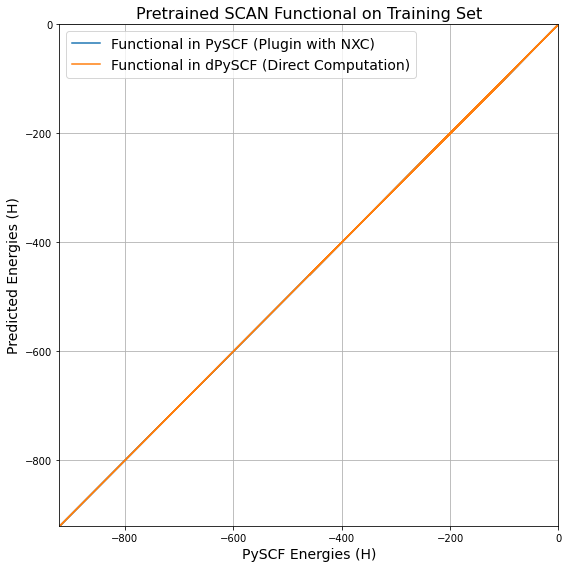

In [118]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)

ex = cce[cce[cc.columns[0]].isin(eve[ev.columns[0]])].values[:, 1] 
ey = eve.values[:, 1]

tx = cce[cce[cc.columns[0]].isin(tre['idx'])].values[:, 1]
ty = tre.values[:, 1]
ax.plot(ex, ey, label='Functional in PySCF (Plugin with NXC)')
ax.plot(tx, ty, label='Functional in dPySCF (Direct Computation)')
ax.grid()
ax.set_ylim(eve.values[:, 1].min(), 0)
ax.set_xlim(eve.values[:, 1].min(), 0)
ax.set_xlabel('PySCF Energies (H)', fontsize=14)
ax.set_ylabel('Predicted Energies (H)', fontsize=14)
ax.legend(fontsize=14)
plt.title("Pretrained SCAN Functional on Training Set", fontsize=16)
plt.tight_layout()

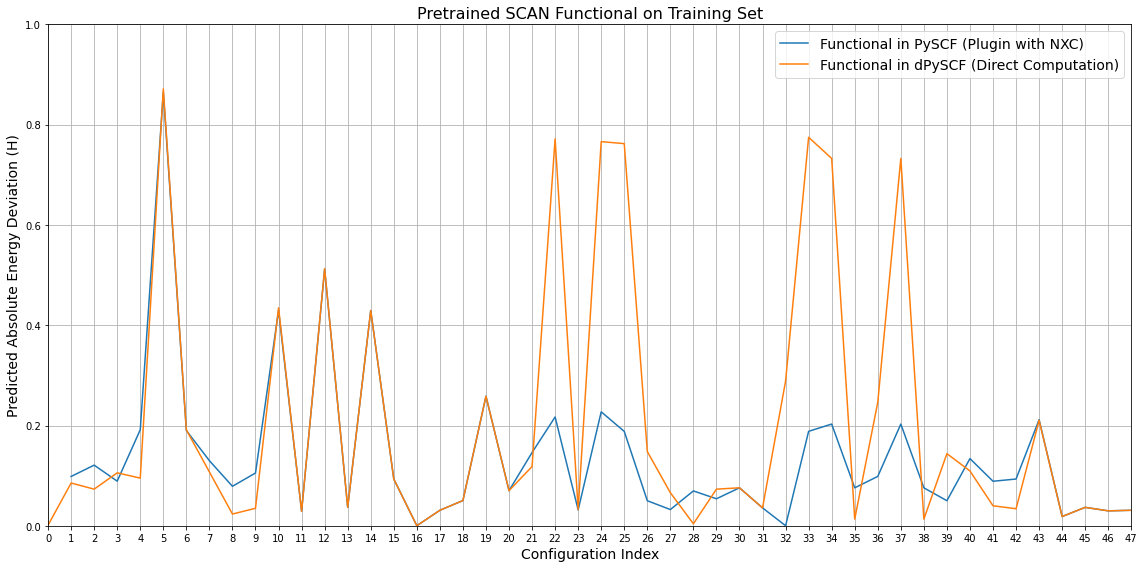

In [120]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)


ex = cce[cce[cc.columns[0]].isin(eve[ev.columns[0]])].values[:, 1] 
ey = eve.values[:, 1]
en = cce[cce[cc.columns[0]].isin(eve[ev.columns[0]])].values[:, 0] 

tx = cce[cce[cc.columns[0]].isin(tre['idx'])].values[:, 1]
ty = tre.values[:, 1]
tn = cce[cce[cc.columns[0]].isin(tre['idx'])].values[:, 0]

ax.plot(en, abs(ex-ey), label='Functional in PySCF (Plugin with NXC)')
ax.plot(tn, abs(tx-ty), label='Functional in dPySCF (Direct Computation)')
ax.grid()
ax.set_ylim(0, 1)
ax.set_xlim(0, len(tn))
ax.set_xlabel('Configuration Index', fontsize=14)
ax.set_ylabel('Predicted Absolute Energy Deviation (H)', fontsize=14)
ax.set_xticks(np.arange(0, 48))
ax.legend(fontsize=14)
plt.title("Pretrained SCAN Functional on Training Set", fontsize=16)
plt.tight_layout()

In [112]:
tn

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47.])

In [85]:
cc

array([-1.09517582e+02, -1.07426924e+02, -9.34107832e+01, -1.88593336e+02,
       -9.20460342e+02, -1.99526540e+02, -1.50256078e+02, -7.73124295e+01,
       -1.13307011e+02, -4.60853159e+02, -8.06696684e+00, -3.24543863e+02,
       -3.78358923e+01, -4.60184245e+02, -9.97341851e+01, -4.99965257e-01,
       -7.47855485e+00, -5.45843432e+01, -1.62260604e+02, -7.50642637e+01,
       -1.29678696e+02, -2.05089988e+02, -5.51241643e+01, -2.25429381e+02,
       -1.84667322e+02, -3.98339135e+01, -3.90972352e+01, -7.64299681e+01,
       -5.65538742e+01, -7.57380100e+01, -3.84665002e+01, -4.99965257e-01,
       -1.84667263e+02, -1.85151909e+02, -7.57380182e+01, -1.09517630e+02,
       -1.85151909e+02, -7.57380182e+01, -3.98339355e+01, -1.15566628e+02,
       -1.00453586e+02, -9.97341806e+01, -2.00045132e+02, -3.74058988e+01,
       -3.78358884e+01, -7.28062074e+00, -7.47855485e+00])

In [2]:
atoms = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/calc_results.traj',':')
print("PARSING NON-ATOMIC NON-REACTION MOLECULES")
molecules = {'{:3d}'.format(idx) + ''.join(a.get_chemical_symbols()): [idx] for idx, a in enumerate(atoms) if len(a.positions) > 1 and not a.info.get('reaction') }
print(molecules)

print("PARSING NEUTRAL, PURE NON-REACTION ATOMS. CHARGE FLAG NOT SET.")
pure_atoms = {''.join(a.get_chemical_symbols()): [idx] for idx, a in enumerate(atoms) if len(a.positions) == 1 and not a.info.get('reaction') and not a.info.get('fractional') and not a.info.get('charge') and not a.info.get('supp')}
print(pure_atoms)
molecules.update(pure_atoms)

print("PARSING SUPPLEMENTAL NEUTRAL, PURE ATOMS (FROM FRAC DATASET)")
n_atoms = {''.join(a.get_chemical_symbols())+'_n0': [idx] for idx, a in enumerate(atoms) if len(a.positions)==1 and a.info.get('supp') and not a.info.get('charge') and not a.info.get('fractional')}
print(n_atoms)

#molecules.update(n_atoms)
print("PARSING SUPPLEMENTAL CHARGED, PURE ATOMS")
c_atoms = {''.join(a.get_chemical_symbols())+'_c{}'.format(a.info['charge']): [idx] for idx, a in enumerate(atoms) if len(a.positions)==1 and a.info.get('supp') and a.info.get('charge')}
print(c_atoms)

#molecules.update(c_atoms)
print("PARSING SUPPLEMENTAL FRACTIONAL ATOMS")
frac_atoms = {''.join(a.get_chemical_symbols())+'_f{}'.format(a.info['fractional']): [idx] for idx, a in enumerate(atoms) if len(a.positions)==1 and a.info.get('supp') and a.info.get('fractional')}
print(frac_atoms)
#molecules.update(frac_atoms)

def cat_dict(dicts, keysplit='_'):
    #To generate the list of atoms comprising a fractional datapoint, for effective reaction
    retdct = {k:[] for k in list(dicts[0].keys())}
    rkeys = sorted(list(retdct.keys()))
    for didx,dct in enumerate(dicts):
        dkeys = sorted(list(dct.keys()))
        for dk in dkeys:
            mkey = [mk for mk in rkeys if dk.split(keysplit)[0] in mk.split(keysplit)[0]][0]
            retdct[mkey] += dct[dk]
    return retdct

fracdct = cat_dict([frac_atoms, n_atoms, c_atoms])
print("CONCATENATING SUPPLEMENTAL/FRACTIONAL ATOMS")
print(frac_atoms)
molecules.update(fracdct)

def split(el):
        import re
        #Splits a string on capital letter sequences
        res_list = [s for s in re.split("([A-Z][^A-Z]*)", el) if s]
        return res_list

for molecule in molecules:
    comp = []
    #ignore _ atoms, charged or fractional
    if '_' in molecule:
        continue
    for a in split(molecule[3:]):
        comp.append(pure_atoms[a][0])
    molecules[molecule] += comp


print("PARSING REACTIONS")
reactions = {}
for idx, a in enumerate(atoms):
    #atom must have reaction flag
    if not a.info.get('reaction'): continue
    #and atom must not be a reactant
    if a.info.get('reaction') == 'reactant': continue
    reactions['{:3d}'.format(idx) + ''.join(a.get_chemical_symbols())] = \
        [idx] + [idx + i for i in np.arange(-a.info.get('reaction'),0,1).astype(int)]
print(reactions)
molecules.update(reactions)


#a_count = {idx: len(at.positions) for idx,at in enumerate(atoms)}
a_count = {a: np.sum([a in molecules[mol] for mol in molecules]) for a in np.unique([m  for mol in molecules for m in molecules[mol]])}

print("MOLECULES TO TRAIN ON")
print(molecules)
print("A_COUNT")
print(a_count)
mol_losses = [] #rho loss
h_losses = [] #rho + e loss
atm_losses = [] #e loss
for idx, at in enumerate(atoms):
    sc = atoms[idx].info.get('sc',True)
    reaction = atoms[idx].info.get('reaction',False)
    fractionFlag = atoms[idx].info.get('fractional', False)
    suppFlag = atoms[idx].info.get('supp', False)
    charge = atoms[idx].info.get('charge', 0)

    if atoms[idx].info.get('radical', False):
        pass
    #If molecule and self-consistent, use "mol_losses" dict
    #Only rho loss
    if len(atoms[idx].positions) > 1 and sc:
        print("MOL_LOSSES")
        mol_losses.append(at.get_chemical_formula())
    #Else, if chosen atom is either H or Li, and args specify use both, and the H/Li not involved in reaction
    #Rho and energy loss
    elif str(atoms[idx].symbols) in ['H', 'Li'] and not reaction:
        print("H_LOSSES")
        h_losses.append(at.get_chemical_formula())
    #Otherwise, if just an atom not in a reaction:
    #Only energy loss -- E_ref for atoms is total atomic, not atomization
    elif sc and not reaction:
        print("ATM_LOSSES")
        atm_losses.append(at.get_chemical_formula())
    #Else empty loss dict if reaction or not sc
    else:
        pass
print("Mol Losses (rho): ", mol_losses)
print("H Losses (rho+E): ", h_losses)
print("Atm Losses (E): ", atm_losses)


PARSING NON-ATOMIC NON-REACTION MOLECULES
{'  0HH': [0], '  1NN': [1], '  2LiF': [2], '  3CNH': [3], '  4COO': [4], '  5ClCl': [5], '  6FF': [6], '  7OO': [7], '  8CCHH': [8], '  9OC': [9], ' 10ClH': [10], ' 11LiH': [11], ' 12NaNa': [12], ' 21NO': [21], ' 22NOO': [22], ' 23NH': [23], ' 24OOO': [24], ' 25NNO': [25], ' 26CHHH': [26], ' 27CHH': [27], ' 28OHH': [28], ' 29NHHH': [29], ' 30OH': [30], ' 31CH': [31], ' 48OHHOHH': [48], ' 49OHHOHH': [49]}
PARSING NEUTRAL, PURE NON-REACTION ATOMS. CHARGE FLAG NOT SET.
{'C': [13], 'Cl': [14], 'F': [15], 'H': [16], 'Li': [17], 'N': [18], 'Na': [19], 'O': [20]}
PARSING SUPPLEMENTAL NEUTRAL, PURE ATOMS (FROM FRAC DATASET)
{}
PARSING SUPPLEMENTAL CHARGED, PURE ATOMS
{}
PARSING SUPPLEMENTAL FRACTIONAL ATOMS
{}
CONCATENATING SUPPLEMENTAL/FRACTIONAL ATOMS
{}
PARSING REACTIONS
{' 34HONN': [34, 32, 33], ' 37HONN': [37, 35, 36], ' 40CHHHHO': [40, 38, 39], ' 43HFF': [43, 41, 42], ' 45C': [45, 44], ' 47Li': [47, 46]}
MOLECULES TO TRAIN ON
{'  0HH': [0, 16, 1

In [4]:
to = np.arange(len(molecules)).astype(int)
to

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [5]:
tst = read('/home/awills/Documents/Research/swxcd/aegis/xcd_scan/results.traj', ':')
li1 = tst[-2]
li2 = tst[-1]

In [12]:
mol = ase_atoms_to_mol(li1)[1]
mol.verbose = 5
mf, _ = gen_mf_mol(mol, xc='scan', grid_level=7)
mfp, _ = gen_mf_mol(mol, xc='pbe', grid_level=5)
mfp = mfp.newton()
mfp.kernel()
#mf.kernel(dm0 = mfp.make_rdm1())
mf.diis_space = 14
mf.kernel()

Building grids...
atom Li rad-grids = 135, ang-grids = [  50   50   50   50   50   50   50   50   50   50   50   50   50   50
   50   50   50   50   50   50   50   50   50   50   50   50   50   50
   50   50   50   50   50   50   50   50   50   50   50   50   50   50
   50   50   50   50   50   50   50   50   50   50   50   86   86   86
   86   86   86   86   86   86   86   86   86   86   86   86   86   86
   86   86   86   86  974  974  974  974  974  974  974  974  974  974
  974  974  974  974  974 1202 1202 1202 1202 1202 1202 1202 1202 1202
 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202
 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202 1202
  974  974  974  974  974  974  974  974  974]
tot grids = 72306
METHOD GENERATED: <function RKS at 0x7fc53166f320>
Building grids...
atom Li rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  

E1 = -8.881060057016354  Ecoul = 3.29143994001138  Exc = -1.6656848536838016
macro= 2  E= -7.25530497068878  delta_E= 4.44089e-15  |g|= 9.49906e-06  1 KF 2 JK
    CPU time for cycle= 3      4.26 sec, wall time      0.25 sec
Canonicalize SCF orbitals
macro X = 3  E=-7.25530497068878  |g|= 9.49906e-06  total 4 KF 13 JK
    CPU time for Second order SCF     15.18 sec, wall time      0.90 sec
converged SCF energy = -7.25530497068878


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 14
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmp1_ppumoz
max_memory 4000 MB (current use 414 MB)
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (20

nelec by numeric integration = 1.9999928099000481
    CPU time for vxc      2.33 sec, wall time      0.16 sec
E1 = -0.5256747311434644  Ecoul = 0.3256359099953402  Exc = -0.22696003863149705
cycle= 7 E= -0.426998859779621  delta_E= -2.73e-10  |g|= 0.513  |ddm|= 1.23e-07
    CPU time for cycle= 7      2.52 sec, wall time      0.17 sec
Linear dependence found in DIIS error vectors.
  HOMO = -26663.2142099978  LUMO = -26225.9912718875
  mo_energy =
[-2.66632142e+04 -2.62259913e+04 -2.50566046e+04 -2.48077052e+04
 -2.43269368e+04 -2.00508398e+04 -1.86411467e+04 -1.82017807e+04
 -1.73132471e+04 -3.48612468e+03 -3.43998612e+03 -3.38528927e+03
 -3.27448799e+03 -3.25601647e+03 -3.14333919e+03 -2.96379791e+03
 -2.18189374e+02 -1.86874092e+02 -1.86855691e+02 -1.86850310e+02
 -2.27160238e+00  1.19060116e-01  1.38659621e-01  1.46424481e-01
  1.50235262e-01  3.23860397e-01  3.26462287e-01  3.27293096e-01
  7.39092753e-01  7.48858931e-01  7.50835757e-01  7.50946751e-01
  7.51895272e-01  2.39806315e+

nelec by numeric integration = 1.9999928098982562
    CPU time for vxc      2.21 sec, wall time      0.14 sec
E1 = -0.5256747318735285  Ecoul = 0.3256359104887581  Exc = -0.22696003881607166
cycle= 15 E= -0.426998860200842  delta_E= 1.09e-10  |g|= 0.513  |ddm|= 4.92e-08
    CPU time for cycle= 15      2.49 sec, wall time      0.16 sec
Linear dependence found in DIIS error vectors.
  HOMO = -2.26868470415119  LUMO = 0.149149268401644
  mo_energy =
[-2.26868470e+00  1.49149268e-01  1.52013606e-01  1.60072221e-01
  1.63770112e-01  3.24765708e-01  3.26023959e-01  3.27055352e-01
  7.90137541e-01  7.92069624e-01  7.93524929e-01  7.95461449e-01
  7.99188848e-01  2.42889947e+00  2.43506252e+00  2.44066922e+00
  2.44259641e+00  2.44845389e+00  3.23339734e+00  2.66470588e+01
  2.66473527e+01  2.66492669e+01  3.10727913e+01  4.45088200e+02
  4.61909956e+02  4.70649207e+02  4.73683561e+02  4.83811550e+02
  4.87617982e+02  4.92566665e+02  2.54152576e+03  2.62420928e+03
  2.66095290e+03  2.89331177e

nelec by numeric integration = 1.9997086740937209
    CPU time for vxc      2.33 sec, wall time      0.14 sec
E1 = -0.6461282246189324  Ecoul = 0.43486363911473647  Exc = -0.2665669177159654
cycle= 23 E= -0.477831503220161  delta_E= -1.74  |g|= 0.455  |ddm|= 5.58
    CPU time for cycle= 23      2.58 sec, wall time      0.16 sec
Linear dependence found in DIIS error vectors.
  HOMO = -175845.341936538  LUMO = -49363.5911792303
  mo_energy =
[-1.75845342e+05 -4.93635912e+04 -4.63296888e+04 -3.88028803e+04
 -2.33741509e+04 -1.95198208e+04 -1.51019956e+04 -1.06200189e+04
 -9.12920776e+03 -7.69018058e+03 -5.75958671e+03 -4.67442444e+03
 -2.76102877e+03 -1.92482623e+03 -1.15780779e+03 -8.58299337e+02
 -6.93631364e+02 -6.14622592e+02 -3.06320889e+02 -1.69391872e+02
 -1.39789757e+02 -7.07061563e+01 -4.94379523e+01 -3.08184580e+01
 -6.71239311e+00 -2.60066425e-01  2.31201328e+01  3.39357587e+01
  5.60146888e+01  7.34758604e+01  1.60376130e+02  3.32603547e+02
  8.33239620e+02  9.03673069e+02  2.

nelec by numeric integration = 1.9989434605129859
    CPU time for vxc      2.32 sec, wall time      0.15 sec
E1 = -0.5243986252172412  Ecoul = 0.3644301140130295  Exc = -0.22212750053241737
cycle= 31 E= -0.382096011736629  delta_E= 0.0205  |g|= 0.468  |ddm|= 4.39
    CPU time for cycle= 31      2.61 sec, wall time      0.16 sec
  HOMO = -3091437.19810816  LUMO = -1053209.53444464
  mo_energy =
[-3.09143720e+06 -1.05320953e+06 -5.69776542e+05 -4.78543496e+05
 -2.41583438e+05 -1.63337408e+05 -1.15967103e+05 -9.37684673e+04
 -7.90834116e+04 -2.29792580e+04 -1.92230967e+04 -1.28390180e+04
 -1.02242493e+04 -7.04924119e+03 -4.89719247e+03 -3.98475828e+03
 -1.45283373e+03 -1.03734269e+03 -3.61035152e+02  9.35637591e+00
  2.10592402e+03  2.77258077e+03  3.14814678e+03  4.49316816e+03
  5.81940247e+03  8.08576184e+03  9.42903384e+03  1.71238477e+04
  1.99013264e+04  2.64818558e+04  3.71486703e+04  4.40435025e+04
  8.72164683e+04  1.16326327e+05  1.40546857e+05  1.79262094e+05
  2.77854804e+05 

nelec by numeric integration = 1.999833271701981
    CPU time for vxc      2.36 sec, wall time      0.16 sec
E1 = -0.5074260163211113  Ecoul = 0.30244589540054045  Exc = -0.22270755173307014
cycle= 39 E= -0.427687672653641  delta_E= 0.0209  |g|= 0.769  |ddm|= 9.59
    CPU time for cycle= 39      2.49 sec, wall time      0.17 sec
  HOMO = -577474.233971664  LUMO = -416043.44920312
  mo_energy =
[-5.77474234e+05 -4.16043449e+05 -3.16654236e+05 -1.73466214e+05
 -1.29363335e+05 -1.08059577e+05 -9.50486533e+04 -6.98481580e+04
 -3.99101314e+04 -3.40364560e+04 -1.01248499e+04 -7.56700458e+03
 -6.99470517e+03 -5.45881011e+03 -1.97644124e+03 -1.58272843e+03
 -6.58577629e+02 -2.84349321e+02  1.12952444e+03  2.86851407e+03
  5.71129142e+03  8.77327332e+03  1.22018776e+04  1.32186613e+04
  1.69118104e+04  2.05482184e+04  3.47165482e+04  3.73189044e+04
  5.33221607e+04  6.18720547e+04  1.18732253e+05  1.38700657e+05
  2.71864912e+05  7.36555602e+05  1.23837720e+06  1.49073580e+06
  4.41569330e+06  

nelec by numeric integration = 1.999953936015413
    CPU time for vxc      2.30 sec, wall time      0.15 sec
E1 = -0.8051029855355116  Ecoul = 0.9263756217910287  Exc = -0.5277939742360153
cycle= 47 E= -0.406521337980498  delta_E= -0.0043  |g|= 0.932  |ddm|= 0.0865
    CPU time for cycle= 47      2.57 sec, wall time      0.16 sec
  HOMO = -766551.832614302  LUMO = -561521.349965417
  mo_energy =
[-7.66551833e+05 -5.61521350e+05 -2.83807518e+05 -2.47201296e+05
 -1.87076482e+05 -1.52388160e+05 -1.27945245e+05 -1.11783415e+05
 -9.10900033e+04 -8.51433773e+04 -7.74866416e+04 -3.91106884e+04
 -3.26568773e+04 -2.40947090e+04 -1.65360715e+04 -9.57547529e+03
 -3.76627083e+03 -3.54358455e+03  1.89259639e+02  2.55007346e+03
  3.18714385e+03  5.21101989e+03  8.28355949e+03  1.15893639e+04
  1.84473433e+04  3.10406244e+04  4.44281157e+04  6.46467171e+04
  1.11683737e+05  1.60481604e+05  1.91496386e+05  2.16444787e+05
  6.90540223e+05  1.11351572e+06  1.94164751e+06  2.12903509e+06
  5.86091134e+06

-0.4447048439628586

In [7]:
mol = ase_atoms_to_mol(li2)[1]
mol.verbose = 5
mf, _ = gen_mf_mol(mol, xc='scan', grid_level=5)
mfp, _ = gen_mf_mol(mol, xc='pbe', grid_level=5)
mfp = mfp.newton()
mfp.kernel()

Building grids...
atom Li rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  86  86  86  86  86  86  86  86  86  86  86  86  86
  86  86  86  86 590 590 590 590 590 590 590 590 590 590 590 770 770 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590]
tot grids = 36462
METHOD GENERATED: <function UKS at 0x7fc53167d320>
Building grids...
atom Li rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  86  86  86  86  86  86  86  86  86  86  86  86  86
  86  86  86  86 590 590 590 590 590 590 590 590 590 590 590 770 770 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 

  beta  mo_energy =
[-1.88580626 -0.02057389  0.01491701  0.01491701  0.01491701  0.01901128
  0.05148184  0.05148184  0.05148184  0.11942747  0.11942747  0.11942747
  0.12472015  0.17210641  0.17210641  0.17210641  0.17210641  0.17210641
  0.45428813  0.45428813  0.45428813  0.5598111   0.5598111   0.5598111
  0.5598111   0.5598111   0.59210742  0.59210742  0.59210742  0.59210742
  0.59210742  0.59210742  0.59210742  2.43235367  2.43235367  2.43235367
  2.43235367  2.43235367  3.41009449]
multiplicity <S^2> = 0.75000049  2S+1 = 2.0000005
E1 = -9.718965374476522  Ecoul = 4.065526772181895  Exc = -1.8066229788083303
macro= 1  E= -7.46006158110296  delta_E= -1.10134e-13  |g|= 2.72823e-06  1 KF 2 JK
    CPU time for cycle= 2      4.72 sec, wall time      0.28 sec
Canonicalize SCF orbitals
macro X = 2  E=-7.46006158110296  |g|= 2.72823e-06  total 4 KF 12 JK
    CPU time for Second order SCF     15.63 sec, wall time      1.00 sec
converged SCF energy = -7.46006158110296  <S^2> = 0.75000049 

-7.460061581102957

In [47]:
mf.diis_space = 14
mf.kernel(dm0=mfp.make_rdm1())



******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.ADIIS'>
diis_start_cycle = 1
diis_space = 14
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmp1opdpsyq
max_memory 4000 MB (current use 1057 MB)
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = scan
    J. Sun, A. Ruzsinszky, and J. P. Perdew, Phys. Rev. Lett. 115, 036402 (2015)
    J. Sun, A. Ruzsinszky, and J. P. Perdew, Phys. Rev. Lett. 115, 036402 (2015)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7f2599c65710>
grids dens level:

nelec by numeric integration = 15.99999999048507
    CPU time for vxc      3.85 sec, wall time      0.26 sec
E1 = -261.8060768645189  Ecoul = 100.42622897500101  Exc = -16.952027974882515
cycle= 5 E= -150.258581574096  delta_E= -0.000587  |g|= 0.125  |ddm|=  1.6
    CPU time for cycle= 5      4.28 sec, wall time      0.28 sec

WARN: HOMO -0.220432361381607 == LUMO -0.220364961727723

  mo_energy =
[-19.10920263 -19.10915656  -1.25213381  -0.77100045  -0.50883977
  -0.48722138  -0.4869241   -0.22043236  -0.22036496   0.10912118
   0.10932759   0.16120866   0.16137094   0.22035853   0.24027773
   0.24751096   0.24776717   0.3617773    0.62790996   0.62796292
   0.84388259   0.84505115   0.84532006   0.85393519   0.95224602
   0.9525538    0.96338114   0.96375114   1.02647469   1.02656915
   1.07006128   1.22857765   1.41526969   1.41550971   1.78505783
   2.30834545   2.86123873   2.86206358   3.05989706   3.18484398
   3.18551486   3.38402275   3.38473941   3.72838683   3.72879015
   4.

nelec by numeric integration = 15.999999990485206
    CPU time for vxc      3.75 sec, wall time      0.25 sec
E1 = -261.8130170771643  Ecoul = 100.43379176490046  Exc = -16.952861002465426
cycle= 11 E= -150.258792024425  delta_E= -1.72e-05  |g|= 0.118  |ddm|=  1.3
    CPU time for cycle= 11      4.44 sec, wall time      0.29 sec

WARN: HOMO -0.22019669450835 == LUMO -0.220148023597319

  mo_energy =
[-19.10848622 -19.10844017  -1.25186754  -0.77079506  -0.50857576
  -0.48689277  -0.48680985  -0.22019669  -0.22014802   0.10916991
   0.10938439   0.16130408   0.16136536   0.22039016   0.2404552
   0.24762187   0.24769735   0.36179805   0.62798119   0.62812187
   0.84402168   0.8452504    0.84536643   0.85405245   0.95255556
   0.95267484   0.96309087   0.96423094   1.02666198   1.02670074
   1.07022437   1.22873254   1.41542817   1.41553767   1.78529634
   2.30850037   2.86187012   2.86211664   3.06015902   3.18489174
   3.18603355   3.38394864   3.38542387   3.72878953   3.72890943
   4

nelec by numeric integration = 15.999999990486327
    CPU time for vxc      3.85 sec, wall time      0.27 sec
E1 = -261.8137497871419  Ecoul = 100.43448442570752  Exc = -16.952911997674747
cycle= 17 E= -150.258883068805  delta_E= -0.000161  |g|= 0.113  |ddm|=  1.4
    CPU time for cycle= 17      5.16 sec, wall time      0.34 sec

WARN: HOMO -0.220269259939778 == LUMO -0.220053985348683

  mo_energy =
[-19.10853375 -19.10848767  -1.25185235  -0.77076864  -0.50855157
  -0.48695346  -0.48672782  -0.22026926  -0.22005399   0.10917256
   0.109383     0.16130203   0.16136407   0.22038858   0.24045269
   0.24762808   0.24769138   0.36179565   0.62793571   0.62816142
   0.84402052   0.84527353   0.84534263   0.85406356   0.95258024
   0.9526967    0.96276314   0.96455742   1.02666377   1.02674024
   1.07026615   1.2287432    1.41545988   1.41550566   1.78529965
   2.30854525   2.86195311   2.86203382   3.06012102   3.18454339
   3.18634429   3.38351309   3.38580949   3.72878868   3.72884136
  

nelec by numeric integration = 15.999999990489897
    CPU time for vxc      3.87 sec, wall time      0.26 sec
E1 = -261.8141337337721  Ecoul = 100.43487644275726  Exc = -16.952916652667177
cycle= 23 E= -150.258879653378  delta_E= -4.31e-05  |g|= 0.112  |ddm|= 1.62
    CPU time for cycle= 23      4.81 sec, wall time      0.31 sec

WARN: HOMO -0.220302075540156 == LUMO -0.220027693084988

  mo_energy =
[-19.10845157 -19.10840552  -1.25179691  -0.77076376  -0.50851301
  -0.48699226  -0.48666967  -0.22030208  -0.22002769   0.10917241
   0.10940707   0.16127686   0.16138631   0.22038799   0.24053723
   0.24760038   0.24772092   0.36179687   0.62799902   0.62812674
   0.84403981   0.84524162   0.84538352   0.85408229   0.95255266
   0.95274223   0.96302715   0.96431158   1.02666804   1.02674315
   1.07026695   1.22877824   1.4154386    1.41554745   1.78529902
   2.30853573   2.86192476   2.86213002   3.06016397   3.18484641
   3.18613079   3.38389083   3.38552466   3.72882833   3.72893977
  

nelec by numeric integration = 15.999999990488503
    CPU time for vxc      3.68 sec, wall time      0.24 sec
E1 = -261.81423497756583  Ecoul = 100.43504571565364  Exc = -16.952971241624493
cycle= 29 E= -150.258866213233  delta_E= -5.73e-05  |g|= 0.113  |ddm|= 1.79
    CPU time for cycle= 29      4.58 sec, wall time      0.29 sec

WARN: HOMO -0.220226248719561 == LUMO -0.2201151227972

  mo_energy =
[-19.10843594 -19.10838989  -1.25181197  -0.77076522  -0.50851279
  -0.48691714  -0.48675051  -0.22022625  -0.22011512   0.10917288
   0.10939338   0.16126495   0.16139849   0.22038795   0.24050163
   0.24757753   0.24773828   0.36179584   0.62801657   0.6281005
   0.84402817   0.84520897   0.84542051   0.85407762   0.95252408
   0.95272411   0.96336066   0.96397873   1.02668281   1.02670119
   1.07026033   1.22875949   1.41537612   1.4155925    1.78528999
   2.30852765   2.86179211   2.86224526   3.06015526   3.18514314
   3.18582493   3.38428121   3.38512307   3.7287473    3.72896796
   4

nelec by numeric integration = 15.999999990488249
    CPU time for vxc      3.73 sec, wall time      0.25 sec
E1 = -261.81365993622626  Ecoul = 100.43451672530263  Exc = -16.952923884643056
cycle= 35 E= -150.258772805263  delta_E= 5.44e-05  |g|= 0.117  |ddm|= 1.86
    CPU time for cycle= 35      4.48 sec, wall time      0.29 sec

WARN: HOMO -0.22022562708065 == LUMO -0.220151415816347

  mo_energy =
[-19.10838775 -19.10834177  -1.25180781  -0.77079483  -0.50855387
  -0.4869463   -0.4867447   -0.22022563  -0.22015142   0.10916798
   0.10939956   0.16124751   0.1614206    0.22038912   0.2405143
   0.24754969   0.24776447   0.36179736   0.62797476   0.6281158
   0.84401091   0.84516822   0.84544482   0.85405866   0.95243057
   0.95272884   0.96314046   0.96417687   1.02665503   1.02667188
   1.07020364   1.22873578   1.41534768   1.41561512   1.78527734
   2.30846927   2.86166122   2.86228339   3.0601952    3.18494199
   3.18599249   3.38400561   3.38536101   3.72868483   3.72901999
   4.

nelec by numeric integration = 15.999999990488403
    CPU time for vxc      3.71 sec, wall time      0.25 sec
E1 = -261.81414756354104  Ecoul = 100.43494539112842  Exc = -16.952989583008453
cycle= 41 E= -150.258897465117  delta_E= -1.43e-05  |g|= 0.113  |ddm|= 1.66
    CPU time for cycle= 41      4.65 sec, wall time      0.30 sec

WARN: HOMO -0.22017574283264 == LUMO -0.220023569941797

  mo_energy =
[-19.10838575 -19.10833973  -1.25182724  -0.770749    -0.50858454
  -0.48686271  -0.48673029  -0.22017574  -0.22002357   0.10917902
   0.10940453   0.16131679   0.16137882   0.2203994    0.24048324
   0.24762517   0.24770968   0.36180369   0.62793585   0.62819184
   0.84403165   0.84525189   0.84538225   0.85404187   0.95254268
   0.9527383    0.96263047   0.96469257   1.02667685   1.02671795
   1.07021091   1.2287274    1.41541598   1.41555603   1.78534813
   2.30849004   2.8618244    2.86216306   3.06022573   3.18434829
   3.18659917   3.38330443   3.38608274   3.72876927   3.72897491
  

nelec by numeric integration = 15.999999990487613
    CPU time for vxc      3.88 sec, wall time      0.26 sec
E1 = -261.81245686459033  Ecoul = 100.43310381580531  Exc = -16.952753019493773
cycle= 47 E= -150.258811777975  delta_E= -4.06e-05  |g|= 0.116  |ddm|= 1.26
    CPU time for cycle= 47      4.64 sec, wall time      0.30 sec

WARN: HOMO -0.220216415878722 == LUMO -0.220159220762705

  mo_energy =
[-19.10848936 -19.10844336  -1.25187161  -0.77081467  -0.5086132
  -0.48696347  -0.48676451  -0.22021642  -0.22015922   0.10916341
   0.109385     0.16124532   0.16142092   0.2203877    0.24045735
   0.24754619   0.24776412   0.36179536   0.62793798   0.62813857
   0.84400306   0.84515404   0.84543741   0.85403254   0.9524277
   0.95273907   0.96287469   0.96441666   1.02664759   1.02666956
   1.07018519   1.22870935   1.41532571   1.41561431   1.78528446
   2.30845198   2.86163285   2.86225144   3.06017116   3.18460634
   3.18626123   3.38361849   3.3856856    3.72865418   3.72899842
   

-150.25872476776652

In [22]:
mol

('O2', <pyscf.gto.mole.Mole at 0x7f258fbdeb50>)

In [6]:
dct= {'a':1, "b":2, "c":4}
for idx, k in enumerate(dct):
    print(idx, k)

0 a
1 b
2 c


In [3]:
z = torch.tensor([0])

In [5]:
if z == 0:
    print('true')

true


In [7]:
rxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/calc_results.traj',':')

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [8]:
hbe = rxnw[48].calc.results['energy']

In [9]:
pte = rxnw[49].calc.results['energy']

In [10]:
print(hbe, pte)
y1 = (hbe-pte)*Hartree

-151.7212731852801 -151.73933198003712


In [11]:
xcdhb = -151.729431405722
xcdpt = -151.717912272695
y2 = (xcdhb-xcdpt)*Hartree

In [12]:
xcdwhb = -151.714352241818
xcdwpt = -151.705428641774
y3 = (xcdwhb - xcdwpt)*Hartree

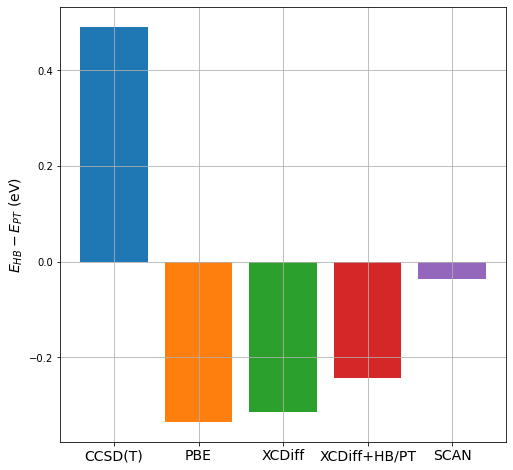

In [19]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
ax.bar(1, y1, label='CCSD(T)')
ax.bar(2, ypbe)
ax.bar(3, y2, label='XCDiff')
ax.bar(4, y3, label='XCDiff+HB/PT')
ax.bar(5, y4)
ax.set_xticks([1,2,3, 4,5])
ax.set_xticklabels(['CCSD(T)', 'PBE', 'XCDiff', 'XCDiff+HB/PT', 'SCAN'], fontsize=14)
ax.set_ylabel('$E_{HB} - E_{PT}$ (eV)', fontsize=14)
plt.grid()


In [40]:
y2/Hartree

-0.01151913302700791

In [3]:
def KS(mol, method, model_path='', nxc_kind='grid', **kwargs):
    """ Wrapper for the pyscf RKS and UKS class
    that uses a libnxc functionals
    """
    #hyb = kwargs.get('hyb', 0)
    mf = method(mol, **kwargs)
    if model_path != '':
        if nxc_kind.lower() == 'atomic':
            model = get_nxc_adapter('pyscf', model_path)
            mf.get_veff = veff_mod_atomic(mf, model)
        elif nxc_kind.lower() == 'grid':
            parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(model_path)
            dft.libxc.define_xc_(mf._numint,
                                 eval_xc,
                                 pylibnxc.pyscf.utils.find_max_level(parsed_xc),
                                 hyb=parsed_xc[0][0])
            mf.xc = model_path
        else:
            raise ValueError(
                "{} not a valid nxc_kind. Valid options are 'atomic' or 'grid'"
                .format(nxc_kind))
    return mf


def eval_xc(xc_code, rho, spin=0, relativity=0, deriv=1, verbose=None):
    """ Evaluation for grid-based models (not atomic)
        See pyscf documentation of eval_xc
    """
    inp = {}
    if spin == 0:
        if rho.ndim == 1:
            rho = rho.reshape(1, -1)
        inp['rho'] = rho[0]
        if len(rho) > 1:
            dx, dy, dz = rho[1:4]
            gamma = (dx**2 + dy**2 + dz**2)
            inp['sigma'] = gamma
        if len(rho) > 4:
            inp['lapl'] = rho[4]
            inp['tau'] = rho[5]
    else:
        rho_a, rho_b = rho
        if rho_a.ndim == 1:
            rho_a = rho_a.reshape(1, -1)
            rho_b = rho_b.reshape(1, -1)
        inp['rho'] = np.stack([rho_a[0], rho_b[0]])
        if len(rho_a) > 1:
            dxa, dya, dza = rho_a[1:4]
            dxb, dyb, dzb = rho_b[1:4]
            gamma_a = (dxa**2 + dya**2 + dza**2)  #compute contracted gradients
            gamma_b = (dxb**2 + dyb**2 + dzb**2)
            gamma_ab = (dxb * dxa + dyb * dya + dzb * dza)
            inp['sigma'] = np.stack([gamma_a, gamma_ab, gamma_b])
        if len(rho_a) > 4:
            inp['lapl'] = np.stack([rho_a[4], rho_b[4]])
            inp['tau'] = np.stack([rho_a[5], rho_b[5]])

    parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(xc_code)
    total_output = {'v' + key: 0.0 for key in inp}
    total_output['zk'] = 0
    #print(parsed_xc)
    for code, factor in parsed_xc[1]:
        model = pylibnxc.LibNXCFunctional(xc_code, kind='grid')
        output = model.compute(inp)
        for key in output:
            if output[key] is not None:
                total_output[key] += output[key] * factor

    exc, vlapl, vtau, vrho, vsigma = [total_output.get(key,None)\
      for key in ['zk','vlapl','vtau','vrho','vsigma']]

    vxc = (vrho, vsigma, vlapl, vtau)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc

In [11]:
#HB
hb = gto.M(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='def2-TZVPD', unit='angstrom')
hb.verbose = 5
hb.charge = 1
hb.spin = 1

#PT
#equilibrium hemibonded configuration: r_{OO} = 2.05 \AA.
pt = gto.M(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='def2-TZVPD')
pt.verbose = 5
pt.charge = 1
pt.spin = 1

In [13]:
smfhb, _ = gen_mf_mol(hb, xc='pbe', grid_level=5)
smfpt, _ = gen_mf_mol(pt, xc='pbe', grid_level=5)
smfhb.kernel()
smfpt.kernel()

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: <function UKS at 0x7f25990e80e0>
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  

  beta  mo_energy =
[-1.88639594e+01 -1.88639576e+01 -1.16101636e+00 -1.14557425e+00
 -7.22379825e-01 -7.09823619e-01 -5.59277299e-01 -5.51954603e-01
 -4.93898252e-01 -4.24735616e-01 -2.30013555e-01 -1.86274494e-01
 -1.45183414e-01 -1.27624454e-01 -9.75765756e-02 -7.38778493e-02
 -5.46710525e-02 -4.79427799e-02 -4.48107709e-02 -3.76030922e-02
 -3.72559688e-02  8.84773036e-03  2.54677735e-02  3.76696802e-02
  3.96161882e-02  8.69614893e-02  8.94216181e-02  9.14999543e-02
  1.11380885e-01  1.27594993e-01  1.33026910e-01  1.43283661e-01
  1.48762308e-01  1.50216427e-01  1.93392451e-01  2.07580269e-01
  2.47756075e-01  2.53826059e-01  2.82247615e-01  2.86654598e-01
  3.16808225e-01  3.25022575e-01  3.38346916e-01  3.62935192e-01
  4.16359018e-01  4.43504546e-01  4.91622687e-01  5.01321923e-01
  5.69496073e-01  5.71083908e-01  5.83521336e-01  6.31548899e-01
  6.95204209e-01  7.14808772e-01  7.16237324e-01  8.51984366e-01
  1.24315384e+00  1.27325833e+00  1.29608465e+00  1.31104660e+00
  1.3

  beta  mo_energy =
[-1.90898237e+01 -1.90898221e+01 -1.23191225e+00 -1.21680112e+00
 -7.79387144e-01 -7.67940811e-01 -6.41579678e-01 -6.38538160e-01
 -5.77974423e-01 -5.11215561e-01 -2.43296252e-01 -2.01585100e-01
 -1.62863199e-01 -1.47057391e-01 -1.09828789e-01 -7.89708270e-02
 -6.33297972e-02 -5.46609927e-02 -5.31827619e-02 -4.51882495e-02
 -4.24911097e-02  2.14243793e-03  2.20647287e-02  3.10873173e-02
  3.13052653e-02  7.70883642e-02  7.85063103e-02  7.89892100e-02
  9.81283241e-02  1.17070866e-01  1.22999032e-01  1.42481090e-01
  1.44376056e-01  1.44904399e-01  1.84154832e-01  1.96308447e-01
  2.36606288e-01  2.44914997e-01  2.68000997e-01  2.71345950e-01
  3.03202912e-01  3.09530773e-01  3.24773401e-01  3.49580195e-01
  4.08946611e-01  4.27888169e-01  4.63947231e-01  4.77897572e-01
  5.39271260e-01  5.48274460e-01  5.53140713e-01  6.12619077e-01
  6.68849230e-01  6.91949067e-01  6.92849749e-01  8.24589664e-01
  1.21788441e+00  1.24121786e+00  1.26580868e+00  1.28928515e+00
  1.2

  beta  mo_energy =
[-1.90899367e+01 -1.90899351e+01 -1.23173100e+00 -1.21660213e+00
 -7.79298166e-01 -7.67843219e-01 -6.41117635e-01 -6.37930007e-01
 -5.77047121e-01 -5.10261819e-01 -2.43394686e-01 -2.01690063e-01
 -1.62793605e-01 -1.47084668e-01 -1.09576209e-01 -7.88988769e-02
 -6.31653360e-02 -5.45987686e-02 -5.29845828e-02 -4.51183301e-02
 -4.24680441e-02  2.23079228e-03  2.20597667e-02  3.11195012e-02
  3.14000928e-02  7.72053479e-02  7.86500893e-02  7.91459271e-02
  9.82602214e-02  1.17297898e-01  1.23159099e-01  1.42518269e-01
  1.44514475e-01  1.45017340e-01  1.84212441e-01  1.96391956e-01
  2.36632832e-01  2.45088312e-01  2.68089919e-01  2.71480794e-01
  3.03294030e-01  3.09757500e-01  3.24866988e-01  3.49760053e-01
  4.08952771e-01  4.27892208e-01  4.63756314e-01  4.77828171e-01
  5.39393275e-01  5.48358958e-01  5.53299994e-01  6.12735640e-01
  6.69158766e-01  6.92119555e-01  6.93038371e-01  8.24668344e-01
  1.21782561e+00  1.24126723e+00  1.26580287e+00  1.28917951e+00
  1.2

  beta  mo_energy =
[-1.90898605e+01 -1.90898589e+01 -1.23171735e+00 -1.21658108e+00
 -7.79314072e-01 -7.67855991e-01 -6.41139506e-01 -6.37942696e-01
 -5.77041762e-01 -5.10254040e-01 -2.43428337e-01 -2.01712814e-01
 -1.62825214e-01 -1.47123660e-01 -1.09606119e-01 -7.89291274e-02
 -6.31946945e-02 -5.46426825e-02 -5.30167523e-02 -4.51585571e-02
 -4.25040679e-02  2.19171813e-03  2.20229312e-02  3.10891951e-02
  3.13640719e-02  7.71723248e-02  7.86234153e-02  7.91155269e-02
  9.82195887e-02  1.17275765e-01  1.23135075e-01  1.42481036e-01
  1.44479258e-01  1.44980329e-01  1.84163403e-01  1.96354729e-01
  2.36583736e-01  2.45051885e-01  2.68039740e-01  2.71437637e-01
  3.03248688e-01  3.09733627e-01  3.24825283e-01  3.49724999e-01
  4.08912322e-01  4.27859265e-01  4.63688788e-01  4.77783022e-01
  5.39370887e-01  5.48328070e-01  5.53266401e-01  6.12700473e-01
  6.69144728e-01  6.92082566e-01  6.93019517e-01  8.24612290e-01
  1.21777595e+00  1.24121849e+00  1.26576321e+00  1.28912711e+00
  1.2

  beta  mo_energy =
[-1.90898617e+01 -1.90898601e+01 -1.23171753e+00 -1.21658125e+00
 -7.79314765e-01 -7.67856707e-01 -6.41140024e-01 -6.37943084e-01
 -5.77042142e-01 -5.10254790e-01 -2.43428977e-01 -2.01713512e-01
 -1.62825849e-01 -1.47124717e-01 -1.09605837e-01 -7.89290263e-02
 -6.31943416e-02 -5.46429668e-02 -5.30163924e-02 -4.51587365e-02
 -4.25039559e-02  2.19186610e-03  2.20228881e-02  3.10889470e-02
  3.13641379e-02  7.71719836e-02  7.86234384e-02  7.91154684e-02
  9.82196642e-02  1.17276063e-01  1.23135434e-01  1.42480920e-01
  1.44479187e-01  1.44980278e-01  1.84163071e-01  1.96354859e-01
  2.36583671e-01  2.45051866e-01  2.68040054e-01  2.71437953e-01
  3.03248793e-01  3.09734015e-01  3.24825461e-01  3.49725157e-01
  4.08911811e-01  4.27858758e-01  4.63688430e-01  4.77782264e-01
  5.39370812e-01  5.48327567e-01  5.53266313e-01  6.12700756e-01
  6.69145011e-01  6.92082522e-01  6.93019755e-01  8.24612035e-01
  1.21777550e+00  1.24121815e+00  1.26576303e+00  1.28912656e+00
  1.2

nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     10.62 sec, wall time      1.39 sec
E1 = -283.5771715678625  Ecoul = 110.1965219702396  Exc = -18.395685268457125
cycle= 1 E= -152.321229753564  delta_E= 0.372  |g|= 0.411  |ddm|= 0.985
    CPU time for cycle= 1     16.18 sec, wall time      1.94 sec
  alpha nocc = 10  HOMO = -0.501141800217545  LUMO = -0.233561183601421
  beta  nocc = 9  HOMO = -0.482150047815243  LUMO = -0.449272408142907
  alpha mo_energy =
[-1.89533507e+01 -1.88098626e+01 -1.19895441e+00 -1.14711694e+00
 -7.58384778e-01 -7.46702856e-01 -6.32960516e-01 -5.70612069e-01
 -5.15806863e-01 -5.01141800e-01 -2.33561184e-01 -1.80877603e-01
 -1.46384777e-01 -1.10125358e-01 -1.02339161e-01 -9.47565914e-02
 -6.00054877e-02 -5.51696897e-02 -4.45487450e-02 -3.29564019e-02
 -6.67251755e-03 -1.62890414e-03  3.13379829e-03  4.18743069e-02
  4.41382713e-02  6.13182615e-02  7.08256215e-02  8.25262323e-02
  1.08483707e-01  1.20048109e-01  1.30571022e-01  1.

multiplicity <S^2> = 0.7518428  2S+1 = 2.001842
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     11.84 sec, wall time      1.67 sec
E1 = -281.8532027658489  Ecoul = 108.1880276133079  Exc = -18.164508479912797
cycle= 3 E= -152.374578519938  delta_E= -0.13  |g|= 0.0502  |ddm|= 0.28
    CPU time for cycle= 3     13.82 sec, wall time      1.88 sec
  alpha nocc = 10  HOMO = -0.571516888418006  LUMO = -0.249630764445459
  beta  nocc = 9  HOMO = -0.5494057538212  LUMO = -0.502641143143733
  alpha mo_energy =
[-1.91151411e+01 -1.91001379e+01 -1.28946938e+00 -1.20582887e+00
 -8.23361547e-01 -8.18858899e-01 -6.96438340e-01 -6.36181495e-01
 -6.16517982e-01 -5.71516888e-01 -2.49630764e-01 -1.92280880e-01
 -1.67754125e-01 -1.19902957e-01 -1.08378031e-01 -1.02600049e-01
 -7.03843152e-02 -6.07231387e-02 -4.97471889e-02 -3.69945669e-02
 -3.22558665e-02 -6.58706260e-03 -1.16470931e-03  3.22724940e-02
  4.12485681e-02  4.96961066e-02  5.78362304e-02  7.28667808e-02
  9.93

multiplicity <S^2> = 0.75226507  2S+1 = 2.0022638
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     10.29 sec, wall time      1.49 sec
E1 = -281.77995988500345  Ecoul = 108.10668453359224  Exc = -18.15739549984637
cycle= 5 E= -152.375565738742  delta_E= -0.000626  |g|= 0.00661  |ddm|= 0.0238
    CPU time for cycle= 5     15.96 sec, wall time      2.10 sec
  alpha nocc = 10  HOMO = -0.562720003492687  LUMO = -0.249183184208436
  beta  nocc = 9  HOMO = -0.540278854881878  LUMO = -0.491431278040825
  alpha mo_energy =
[-1.91063282e+01 -1.90919648e+01 -1.29074196e+00 -1.19691477e+00
 -8.23373497e-01 -8.19228866e-01 -6.89382979e-01 -6.28543077e-01
 -6.15761480e-01 -5.62720003e-01 -2.49183184e-01 -1.90108547e-01
 -1.67723550e-01 -1.18904672e-01 -1.07192823e-01 -1.01229833e-01
 -6.91346283e-02 -5.97116478e-02 -4.82958971e-02 -3.60747148e-02
 -3.08540547e-02 -5.71040370e-03 -1.84370022e-04  3.36596505e-02
  4.25051515e-02  5.04026008e-02  5.86611377e-02  7.4249619

multiplicity <S^2> = 0.7523635  2S+1 = 2.0023621
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc     10.04 sec, wall time      1.58 sec
E1 = -281.79995046820403  Ecoul = 108.12946197693252  Exc = -18.160202329800878
cycle= 7 E= -152.375585708556  delta_E= -2.27e-06  |g|= 0.000839  |ddm|= 0.00312
    CPU time for cycle= 7     15.38 sec, wall time      2.15 sec
  alpha nocc = 10  HOMO = -0.562745913835909  LUMO = -0.249236930329049
  beta  nocc = 9  HOMO = -0.540203889951284  LUMO = -0.491298097804543
  alpha mo_energy =
[-1.91061635e+01 -1.90919787e+01 -1.29082187e+00 -1.19697922e+00
 -8.23486449e-01 -8.19325850e-01 -6.89423887e-01 -6.28515485e-01
 -6.15961364e-01 -5.62745914e-01 -2.49236930e-01 -1.90104150e-01
 -1.67808287e-01 -1.18978082e-01 -1.07177434e-01 -1.01268530e-01
 -6.92054903e-02 -5.97920679e-02 -4.82877216e-02 -3.61282346e-02
 -3.08527063e-02 -5.75634176e-03 -1.89165936e-04  3.36298658e-02
  4.24837482e-02  5.03655518e-02  5.86226818e-02  7.42128

multiplicity <S^2> = 0.75237825  2S+1 = 2.0023768
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      9.61 sec, wall time      1.37 sec
E1 = -281.79980991997036  Ecoul = 108.12929796269876  Exc = -18.160181508325817
cycle= 9 E= -152.375588353081  delta_E= -9e-07  |g|= 0.000153  |ddm|= 0.00426
    CPU time for cycle= 9     12.40 sec, wall time      1.69 sec
  alpha nocc = 10  HOMO = -0.562731496602054  LUMO = -0.249218109448643
  beta  nocc = 9  HOMO = -0.540199600161555  LUMO = -0.491295921855098
  alpha mo_energy =
[-1.91061697e+01 -1.90919838e+01 -1.29078871e+00 -1.19697916e+00
 -8.23463899e-01 -8.19292160e-01 -6.89412205e-01 -6.28416011e-01
 -6.16026427e-01 -5.62731497e-01 -2.49218109e-01 -1.90102415e-01
 -1.67786726e-01 -1.18987744e-01 -1.07124906e-01 -1.01252839e-01
 -6.92079315e-02 -5.98024526e-02 -4.82597054e-02 -3.61199306e-02
 -3.08251036e-02 -5.74604981e-03 -1.65027054e-04  3.36250346e-02
  4.24853506e-02  5.03882053e-02  5.86250358e-02  7.4212200

  6.64705263e+00  6.84230027e+00  4.29683214e+01  4.32903422e+01]
multiplicity <S^2> = 0.75237219  2S+1 = 2.0023708
nelec by numeric integration = [9.99999999 8.99999999]
    CPU time for vxc      8.65 sec, wall time      1.09 sec
E1 = -281.7999278693339  Ecoul = 108.12942119711562  Exc = -18.160186849973755
cycle= 11 E= -152.375588409676  delta_E= -9.58e-10  |g|= 9.9e-06  |ddm|= 0.0001
    CPU time for cycle= 11     12.38 sec, wall time      1.49 sec
  alpha nocc = 10  HOMO = -0.562731166442857  LUMO = -0.249217201912536
  beta  nocc = 9  HOMO = -0.540202359962557  LUMO = -0.491298884007249
  alpha mo_energy =
[-1.91061671e+01 -1.90919818e+01 -1.29078677e+00 -1.19697795e+00
 -8.23461822e-01 -8.19289520e-01 -6.89412277e-01 -6.28413686e-01
 -6.16026378e-01 -5.62731166e-01 -2.49217202e-01 -1.90106594e-01
 -1.67785195e-01 -1.18987646e-01 -1.07124442e-01 -1.01253023e-01
 -6.92080407e-02 -5.98028590e-02 -4.82610812e-02 -3.61202786e-02
 -3.08241098e-02 -5.74586052e-03 -1.65698706e-04  3.3623

-152.3755884097116

In [14]:
smfpt = smfpt.newton()

In [15]:
smfpt.kernel()





******** <class 'pyscf.dft.uks.UKS'> ********
method = UKS-UHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmp1is167qv
max_memory 4000 MB (current use 2588 MB)
number electrons alpha = 10  beta = 9
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (

  beta  mo_energy =
[-1.91062253e+01 -1.90680873e+01 -1.29034800e+00 -1.13903939e+00
 -8.22536759e-01 -8.18006627e-01 -6.70127973e-01 -6.17684848e-01
 -5.40202517e-01 -4.91298913e-01 -2.47379923e-01 -1.82740461e-01
 -1.67649879e-01 -1.13700849e-01 -1.02954318e-01 -9.72472365e-02
 -6.46176214e-02 -5.41236499e-02 -4.53387537e-02 -3.40722892e-02
 -2.61345747e-02 -2.61735703e-03  2.38505680e-03  3.67992487e-02
  4.81265499e-02  5.26149519e-02  6.31735719e-02  8.07478693e-02
  1.01021483e-01  1.14084509e-01  1.27944481e-01  1.38008686e-01
  1.58434775e-01  1.88636237e-01  2.10064336e-01  2.27969523e-01
  2.36539342e-01  2.44778819e-01  2.54169186e-01  2.85066789e-01
  3.22412128e-01  3.31403343e-01  3.44101891e-01  3.70536580e-01
  4.29713146e-01  4.42156926e-01  4.67453555e-01  4.99540142e-01
  5.03808103e-01  5.38243264e-01  5.63536643e-01  6.45255247e-01
  6.61695223e-01  7.49611947e-01  7.75260767e-01  8.87127441e-01
  1.23304227e+00  1.25019609e+00  1.25874766e+00  1.27538733e+00
  1.3

-152.37558840971678

In [16]:
smfpt, _ = gen_mf_mol(pt, xc='scan', grid_level=5)
smfpt.xc='scan,scan'
mf = smfpt.newton()
mf.kernel()

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: <function UKS at 0x7f25990e80e0>




******** <class 'pyscf.dft.uks.UKS'> ********
method = UKS-UHF
initial guess = minao
damping factor = 0
level_shift factor = 

NotImplementedError: meta-GGA

In [15]:
smfhb.get_k()

array([[[ 5.31577746,  4.10710619,  1.33778146, ...,  0.04608588,
          0.00709484, -0.01378128],
        [ 4.10710619,  3.7037801 ,  1.59072365, ...,  0.09361958,
          0.01260072, -0.02747592],
        [ 1.33778146,  1.59072365,  1.58429732, ...,  0.21100023,
          0.02700305, -0.06085825],
        ...,
        [ 0.04608588,  0.09361958,  0.21100023, ...,  0.14648611,
          0.0261991 , -0.03905741],
        [ 0.00709484,  0.01260072,  0.02700305, ...,  0.0261991 ,
          0.14663798, -0.07985603],
        [-0.01378128, -0.02747592, -0.06085825, ..., -0.03905741,
         -0.07985603,  0.205401  ]],

       [[ 5.30862855,  4.09686581,  1.33212563, ...,  0.04575135,
          0.00726694, -0.01380413],
        [ 4.09686581,  3.66907845,  1.54579174, ...,  0.08999929,
          0.01178807, -0.0263085 ],
        [ 1.33212563,  1.54579174,  1.47561813, ...,  0.20080638,
          0.02363749, -0.05719539],
        ...,
        [ 0.04575135,  0.08999929,  0.20080638, ...,  

In [15]:
ypbe = (smfhb.e_tot - smfpt.e_tot)*Hartree

In [10]:
smfhb, _ = gen_mf_mol(hb, xc='scan', grid_level=5)
smfpt, _ = gen_mf_mol(pt, xc='scan', grid_level=5)
smfhb.kernel()
smfpt.kernel()

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: <function UKS at 0x7f25990e80e0>
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  

  beta  mo_energy =
[-1.90917135e+01 -1.90917121e+01 -1.21754992e+00 -1.20166770e+00
 -7.48090710e-01 -7.35588699e-01 -5.84552918e-01 -5.81126217e-01
 -5.06397483e-01 -4.27578058e-01 -1.99388738e-01 -1.54867546e-01
 -1.13080140e-01 -9.23131099e-02 -7.23472340e-02 -4.58861282e-02
 -2.63233427e-02 -2.19461941e-02 -1.55713962e-02 -1.47987600e-02
 -2.76750908e-03  4.20021663e-02  6.38887321e-02  6.60423574e-02
  7.49657755e-02  1.21804774e-01  1.24515143e-01  1.27223318e-01
  1.48809820e-01  1.71221435e-01  1.72004534e-01  1.90078434e-01
  1.95861719e-01  1.97163524e-01  2.41224606e-01  2.52165519e-01
  2.89995761e-01  3.10281017e-01  3.23041917e-01  3.32041057e-01
  3.60181293e-01  3.81734652e-01  3.82607017e-01  4.14868176e-01
  4.79431296e-01  5.06275789e-01  5.46191451e-01  5.53535711e-01
  6.27935992e-01  6.39436855e-01  6.46231400e-01  6.87102552e-01
  7.51055201e-01  7.76141689e-01  7.80227648e-01  9.25626896e-01
  1.32360323e+00  1.35146224e+00  1.37429911e+00  1.38982845e+00
  1.4

  beta  mo_energy =
[-1.92912955e+01 -1.92912943e+01 -1.27532967e+00 -1.25958061e+00
 -7.97267485e-01 -7.85487232e-01 -6.56104013e-01 -6.56000538e-01
 -5.73056579e-01 -4.95490703e-01 -2.11228966e-01 -1.67647542e-01
 -1.28090124e-01 -1.11194612e-01 -8.00871367e-02 -4.90326442e-02
 -3.18743098e-02 -2.54519665e-02 -2.53234716e-02 -1.90143579e-02
 -7.36942375e-03  3.56199316e-02  5.63063946e-02  6.00688188e-02
  7.13891391e-02  1.10369398e-01  1.16155166e-01  1.21064292e-01
  1.36431487e-01  1.61276248e-01  1.62342805e-01  1.85784633e-01
  1.91050044e-01  1.95571790e-01  2.32519245e-01  2.42078745e-01
  2.79549052e-01  3.02348866e-01  3.08979831e-01  3.17219198e-01
  3.47068106e-01  3.68746950e-01  3.69686125e-01  4.02415838e-01
  4.71696455e-01  4.90142169e-01  5.16671198e-01  5.41404717e-01
  6.00111791e-01  6.17226375e-01  6.18077650e-01  6.73159929e-01
  7.29289407e-01  7.58186269e-01  7.58486916e-01  9.00988614e-01
  1.30017136e+00  1.32358849e+00  1.34724025e+00  1.36893986e+00
  1.3

KeyboardInterrupt: 

In [5]:
y4 = (smfhb.e_tot - smfpt.e_tot)*Hartree

In [6]:
_, hbm = gen_mf_mol(hb, xc='notnull', grid_level=5, nxc=True)
_, ptm = gen_mf_mol(pt, xc='notnull', grid_level=5, nxc=True)

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: functools.partial(<function KS at 0x7fcb8db678c0>, method=<function UKS at 0x7fcb7b9a1320>)
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50

In [7]:
xcdwp = '/home/awills/Documents/Research/swxcd/eval/xcdw5/MODEL_MGGA_e29_day4/xc'
xcdp = '/home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA'
hbmf = KS(hb, hbm, model_path=xcdp, nxc_kind='grid')
ptmf = KS(pt, ptm, model_path=xcdp, nxc_kind='grid')

In [8]:
hbmf.grids.level = 5
hbmf.density_fit()
hbmf.kernel()

ptmf.grids.level = 5
ptmf.density_fit()
ptmf.kernel()



******** <class 'pyscf.dft.uks.UKS'> ********
method = UKS-UHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmpv1af6f1q
max_memory 4000 MB (current use 871 MB)
number electrons alpha = 10  beta = 9
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = /home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA


KeyError: 'Unknown compound XC functional  /HOME/AWILLS/DOCUMENTS/RESEARCH/DPYSCFL/MODELS/XCDIFF/MODEL_MGGA'

In [1]:
tstd = {'E': 0}
tstd2 = {'rho': 0}
tstd3 = {'rho':0, 'E':0}

In [3]:
'rho' in tstd2.keys()

True

In [26]:
rp = '/home/awills/Documents/Research/swxcd/seawulf/g297/'
rt = 'results.traj'
atoms = read(os.path.join(rp, rt), ':')

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [27]:
atoms

[Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='P2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='S2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='SH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='OS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='C2H', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CF4', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CH4', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='SCS', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='FOF', pbc=False, calculator=SinglePointCalc

In [23]:
atoms[48].get_chemical_symbols()

['O', 'H', 'H', 'O', 'H', 'H']

In [28]:
symbs = []
for at in atoms:
    symbs += at.get_chemical_symbols()
symbs = list(set(symbs))

In [29]:
symbs

['N', 'S', 'C', 'Li', 'Be', 'Na', 'Si', 'Al', 'H', 'O', 'F', 'P', 'B', 'Cl']

In [19]:
symbats = [Atoms(symbols=s) for s in symbs]

In [21]:
symbmols = [ase_atoms_to_mol(at) for at in symbats]

In [22]:
symbmols

[('N', <pyscf.gto.mole.Mole at 0x7fcb702124d0>),
 ('Li', <pyscf.gto.mole.Mole at 0x7fcb77c499d0>),
 ('C', <pyscf.gto.mole.Mole at 0x7fcb782cb190>),
 ('Na', <pyscf.gto.mole.Mole at 0x7fcb77c5dad0>),
 ('H', <pyscf.gto.mole.Mole at 0x7fcb77f892d0>),
 ('O', <pyscf.gto.mole.Mole at 0x7fcb77d11ed0>),
 ('F', <pyscf.gto.mole.Mole at 0x7fcb706c0550>),
 ('Cl', <pyscf.gto.mole.Mole at 0x7fcb782cf790>)]

In [25]:
gen_mf_mol??